## A quick tour through `nanotext`

We have our favourite pet, some isolate of the order _Gemmatimonadales_. We want to find genomes, whose genome "content" -- defined as the sequence of protein domains -- is similar to the clone we isolated. So let's load all genomes in the GTDB database of phylum _Gemmatimonadota_, just to capture a bit of context, too.

But before we start, you need to download some data for us to play with and import a couple of libraries. We put all large files using the [Open Science Framework (OSF)](https://osf.io) because [reasons](http://ivory.idyll.org/blog/2017-osf-for-files.html). Go to the [project page](https://osf.io/pjf7m/) and download and unpack the following files:

- `gtdb_r89_v2019-02-20.db`
- `models.zip`
- `tara.zip`

Now place the notebook in the folder you downloaded these files into. Good, thank you. Let's start:

```bash
# enter this in the Terminal
jupyter notebook tara.ipynb
```

In [3]:
from glob import glob
import os

import altair as alt
from altair import Color, Scale
alt.renderers.enable('notebook')

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap

from nanotext.classes import GenomeModel
from nanotext.io import dbopen
from nanotext.utils import get_taxa_from_names, get_names_from_taxon, cosine

In [4]:
db = 'gtdb_r89_v2019-02-20.db'

# We adopt the GTDB notation of "<first-letter-of-rank>__<name>" to specify taxa.
gemmas = get_names_from_taxon(db, 'p__Gemmatimonadota')

We identify 113 genome records in the GTDB metadata, some of which will not have made it into the final r89 taxonomy because their quality was too low. Next, we load our model.

`nanotext` is trained on protein domains on genomes, and we provide three models where each model weights domain occurence differently: "core" focuses on frequent domains and is most in line with the original _Word2Vec_ algorithm settings. The "accessory" model focuses on rare domains, and will be much more able to distinguish subtle differences between two isolates. This comes at the cost of greater sensitivity towards genome incompleteness -- if one of those rare domains is missing, the prediction will be more inaccurate than with the "core" model. _If in doubt, ensemble._ Our "ensemble" model averages over 3 models: "core", "accessory" and one which treats each domain with equal weight.

We have found "core" to work well when inferring MAGs which might be incomplete, and "ensemble" to capture the relations in a collection (such as the GTDB) best.

In [5]:
fp_models = 'models'
model = GenomeModel(fp_models, mode='core', norm='l2')

Subtracting mean from model(s) ...
Indexing model(s) ...
l2 norm will be applied to vectors


In [6]:
cosine(model['GCA_003529605.1'], model['GCA_002433265.1'])

0.9455933

We now infer genome vectors for each MAG in the _Delmont et al._ collection. For this we need the Pfam annotations generated either by `hmmer` or its popular wrapper `pfam_scan.pl` (you can find the corresponding workflow in the GitHub repo). Inferring all 957 genomes will take a couple of minutes, so now is a good time to grab some coffee.

In [ ]:
fp = 'tara/*'
files = glob(fp)

inference = {}

for i in tqdm(files):
    name = os.path.basename(i).strip('_pfam.tsv')
    v = model.infer(i, fmt='pfamscan', steps=1000)
    inference[name] = v

 88%|████████▊ | 845/957 [14:10<01:36,  1.16it/s]

Since we are interested in all _Gemmatimonadota_, we now identify those vectors whose nearest neighbor is from this phylum and has a specified minimum distance.

In [9]:
assert len(inference.keys()) == 957  # sanity check

putative_gemmas = set()
mincos = 0.7  # threshold for minimum cosine similarity for kNN search
topn = 1

for name, v in inference.items():
    for hit, cos in model.search(v, topn, mincos):
        if hit in gemmas:
            putative_gemmas.update([name])

non_gemmas = [i for i in inference.keys() if i not in putative_gemmas]
print('The following putative Gemmatimonadota were identified:')
for i in putative_gemmas: print(i)

The following putative Gemmatimonadota were identified:
TARA_ANE_MAG_00005
TARA_RED_MAG_00040
TARA_ION_MAG_00042
TARA_RED_MAG_00069
TARA_RED_MAG_00065


We will now project all the inferred Tara genome vectors together with those from the GTDB of phylum _Gemmatimonadota_ into 2 dimensions using t-SNE (for larger sets of genomes, [`UMAP`](https://github.com/lmcinnes/umap) is a great alternative). We then mark the genomes which we identified as canditates, and make the visualisation interactive for you to explore. For comparison, we include the (precomputed) MinHash estimate of [`sourmash`](https://github.com/dib-lab/sourmash), i.e. the nearest neighbor search using not functional but nucleotide distance.

In [13]:
# emb .. embedding, i.e. a dict to lookup vectors
emb_putative = {k: v.squeeze() for k, v in inference.items() if k in putative_gemmas}
emb_non = {k: v.squeeze() for k, v in inference.items() if k in non_gemmas}
emb_gemmas = model.subset(gemmas) 
emb_gemmas = {k: v.squeeze() for k, v in emb_gemmas.items()}

d = {**emb_gemmas, **emb_putative, **emb_non}
m = np.array(list(d.values()), dtype='float32')

df1 = get_taxa_from_names(db, emb_gemmas.keys())
l = []
for k, v in emb_putative.items():
    l.append([k] + 7*['putative (nanotext)'])

for k, v in emb_non.items():
    l.append([k] + 7*['negative'])
df2 = pd.DataFrame.from_records(l)
df2.columns = df1.columns
df = pd.concat([df1, df2])

c1, c2 = zip(*TSNE(n_components=2).fit_transform(m))
df['c1'] = c1
df['c2'] = c2


# sourmash nearest neighbor
nn = {
    'TARA_ANE_MAG_00005': ('GCA_002339385.1', 0.8571),
    'TARA_RED_MAG_00040': ('GCA_002348465.1', 0.7626),
    'TARA_ION_MAG_00042': ('GCA_002348465.1', 0.5340),
    'TARA_RED_MAG_00065': ('GCA_002724575.1', 0.3684),
    'TARA_RED_MAG_00069': ('GCA_002377615.1', 0.4721),
}

df.set_index('name', inplace=True)
df['name'] = df.index  # this column is needed for plotting later
for k, v in nn.items():
    name, _ = v
    for rank in 'domain phylum class order family genus species'.split():
        df.at[name, rank] = 'putative (MinHash)'


49 records not found


`nanotext` provides a couple of convenience functions to for example query the taxonomy of any model vector (derived from the GTDB).

In [15]:
get_taxa_from_names(db, ['GCA_002339385.1'])

,name,domain,phylum,class,order,family,genus,species
0,GCA_002339385.1,Bacteria,Gemmatimonadota,Gemmatimonadetes,SG8-23,UBA6960,UBA2589,


You can explore the visualisation by zooming in and out; on hovering over a point, it's ID is displayed.

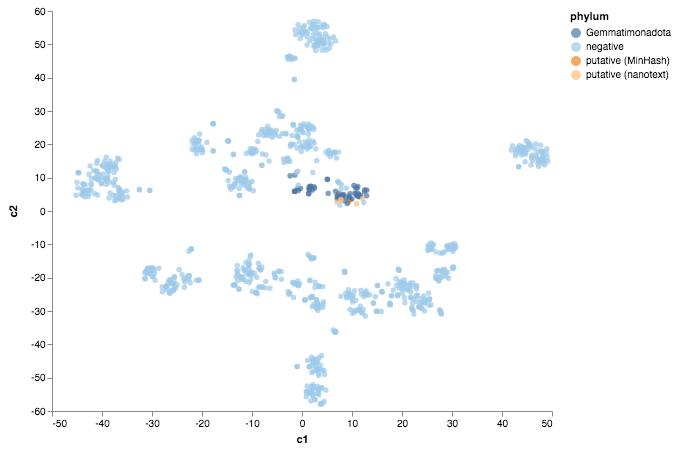

In [17]:
alt.data_transformers.enable('default', max_rows=None)

cols = Color('phylum:N', scale=alt.Scale(scheme='tableau20'))
# change "phylum" to any other rank to have taxonomy coloured, too

pointer = alt.selection_single(on='mouseover', empty='none')
base = alt.Chart(width=500, height=400).encode(x='c1:Q', y='c2:Q')

chart = alt.layer(
    base.mark_circle().properties(selection=pointer).encode(color=cols),
    base.mark_text(dx=8, dy=3, align='left').encode(text=alt.condition(pointer, 'name', alt.value(''))),
    data=df,
).configure_axis(
    grid=False
).configure_view(
    strokeOpacity=0
)

chart.interactive()

And that's it. Any suggestions are welcome, and if your use case is not covered by the current `nanotext` implementation, tell us so on the GitHub issue tracker.